# Анализ рекламной кампании

<b>В компании Procrastinate Pro+ вложения в рекламу принесло только убытки. Главная задача провести анализ и понять, что мешает компании привлекать новых клиентов и их удерживать. \
Для анализа есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:\
-лог сервера с данными об их посещениях,\
-выгрузка их покупок за этот период,\
-рекламные расходы.\
Для этого я изучу:\
-откуда приходят пользователи и какими устройствами они пользуются,\
-сколько стоит привлечение пользователей из различных рекламных каналов;\
-сколько денег приносит каждый клиент,\
-когда расходы на привлечение клиента окупаются,\
-какие факторы мешают привлечению клиентов. </b>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Загрузим данные и подготовим их к анализу

In [ ]:
#Посмотрим на структуру данных
display(visits.head())
display()
visits.info()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [ ]:
display(orders.head())
print()
orders.info()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [ ]:
display(costs.head())
print()
costs.info()

           dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Пропусков в данных нет, так что надо проверить только типы данных и дубликаты

In [ ]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


<b>Явных дубликатов нет</b>

In [ ]:
#Привидем таблицы к нижнему регистру
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

In [ ]:
#Приведем user id к нормальному виду
visits.rename(columns = {'user id':'user_id','session start':'session_start','session end':'session_end'}, inplace = True )
orders.rename(columns = {'user id':'user_id','event dt' : 'event_dt'}, inplace = True )

In [ ]:
#Приведем все столбцы к нужному типу данных
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

## Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Зададим несколько функций которые помогут нам далее

In [ ]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )
    
    

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь
            # среди тех, кто совершил событие event
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )
    new_users['dt'] = pd.to_datetime(new_users['dt'])
    
    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [ ]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [ ]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


In [ ]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [ ]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [ ]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(10,30))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(6, 1, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(6, 1, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(6, 1, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(6, 1, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(6, 1, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


## Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

array([<AxesSubplot:>], dtype=object)

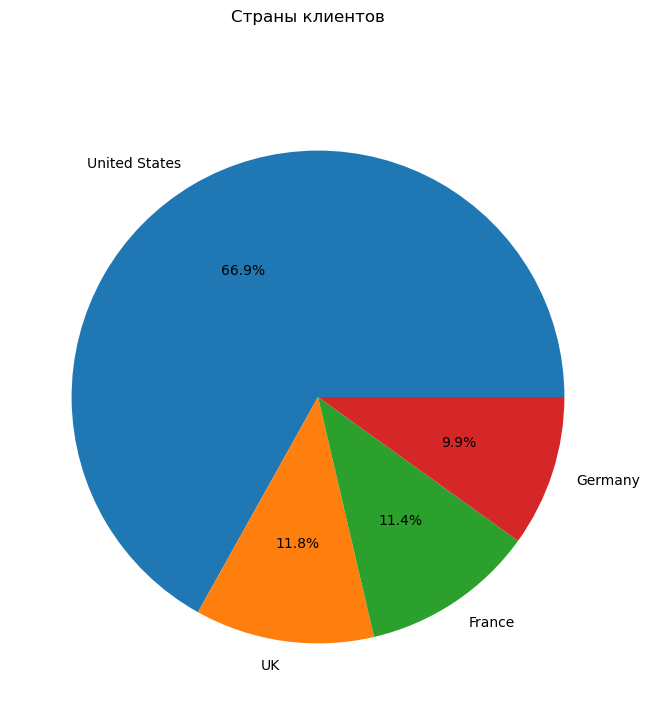

In [ ]:
visits.pivot_table(index='region',values=set(['user_id']),aggfunc='count').sort_values('user_id',ascending=False)\
.plot(kind='pie',subplots=True,figsize=(8,8),autopct='%1.1f%%',legend=False, ylabel='',title='Страны клиентов')

array([<AxesSubplot:>], dtype=object)

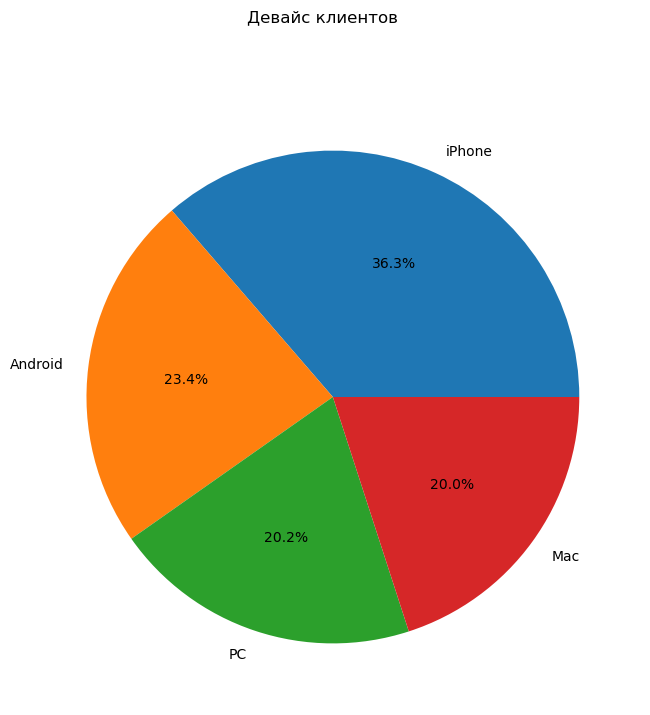

In [ ]:
visits.pivot_table(index='device',values=set(['user_id']),aggfunc='count').sort_values('user_id',ascending=False)\
.plot(kind='pie',subplots=True,figsize=(8,8),autopct='%1.1f%%',legend=False, ylabel='',title='Девайс клиентов')

array([<AxesSubplot:>], dtype=object)

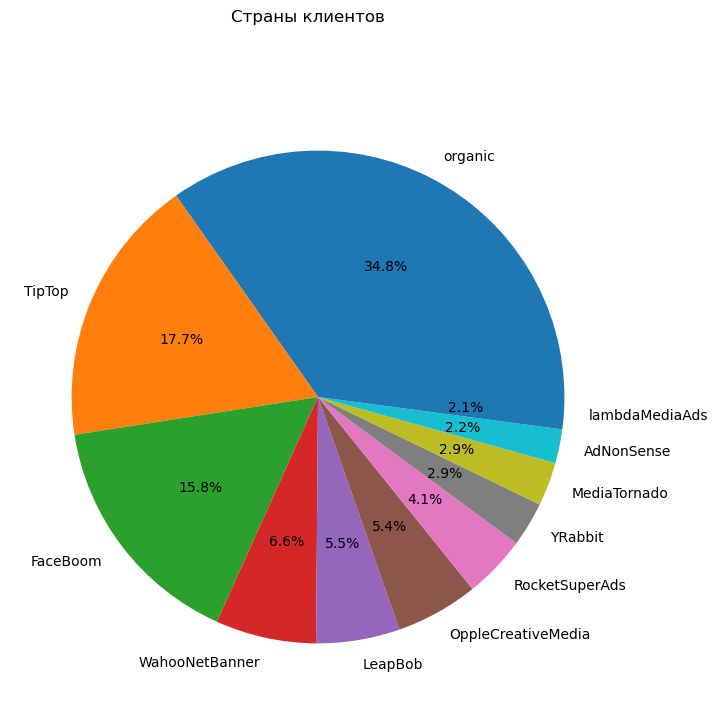

In [ ]:
visits.pivot_table(index='channel',values=set(['user_id']),aggfunc='count').sort_values('user_id',ascending=False)\
.plot(kind='pie',subplots=True,figsize=(8,8),autopct='%1.1f%%',legend=False, ylabel='',title='Страны клиентов')

Проанализировав таблицу visits, можно увидеть что большинство клиентов из United States, по девайсам большой разницы нет, но Iphone имеет небольшой перевес. Около трети пользователей - органические. Но это данные только по зарегистрированным пользователям, дальше будет анализ платящих.

In [ ]:
#Создадим таблицу с платящими пользователями
pay_client = visits.merge(
    orders, on = 'user_id', how='right'
)
pay_client = pay_client.drop_duplicates(subset='user_id').reset_index(drop = True)

In [ ]:
profiles = get_profiles(visits,orders,costs,costs)

In [ ]:
region_buyer = pd.DataFrame()
region_buyer['users'] = profiles.groupby('region')['user_id'].count()
region_buyer['users_part'] = ((region_buyer['users'] / profiles['region'].count()) * 100)
region_buyer['payer'] = profiles.groupby('region').agg({'payer': 'sum'})
region_buyer['payer_part'] = ((region_buyer['payer'] / profiles.query('payer == True')['region'].count()) * 100)
region_buyer.sort_values(by='payer_part', ascending=False).style.format({'payer_part': '{:.2f}%'})

,users,users_part,payer,payer_part
region,,,,
United States,100002,66.664445,6902,77.72%
UK,17575,11.716042,700,7.88%
France,17450,11.632713,663,7.47%
Germany,14981,9.986801,616,6.94%


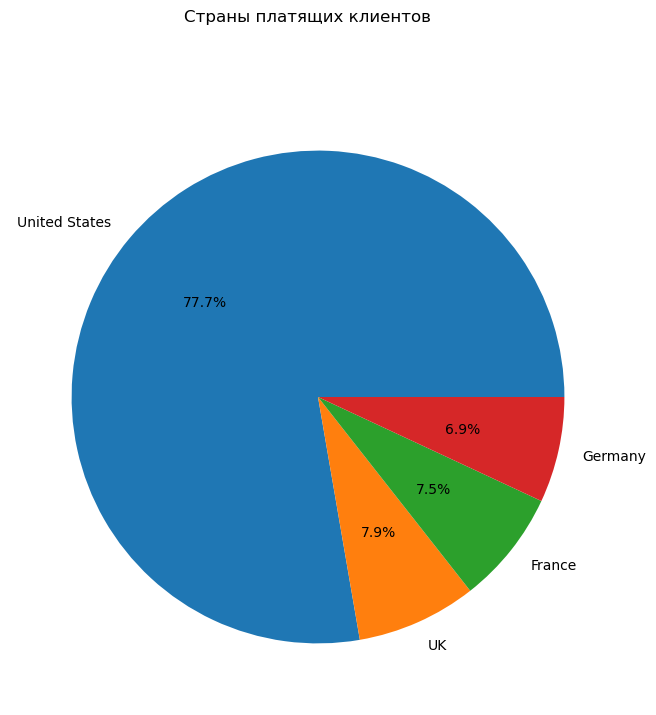

In [ ]:
pay_client.pivot_table(index=['region'],values=['user_id'],aggfunc='count').sort_values('user_id',ascending=False)\
.plot(kind='pie',subplots=True,figsize=(8,8),autopct='%1.1f%%',legend=False, ylabel='',title='Страны платящих клиентов');

In [ ]:
region_buyer = pd.DataFrame()
region_buyer['users'] = profiles.groupby('device')['user_id'].count()
region_buyer['users_part'] = ((region_buyer['users'] / profiles['region'].count()) * 100)
region_buyer['payer'] = profiles.groupby('device').agg({'payer': 'sum'})
region_buyer['payer_part'] = ((region_buyer['payer'] / profiles.query('payer == True')['device'].count()) * 100)
region_buyer.sort_values(by='payer_part', ascending=False).style.format({'payer_part': '{:.2f}%'})

,users,users_part,payer,payer_part
device,,,,
iPhone,54479,36.317396,3382,38.08%
Android,35032,23.353421,2050,23.08%
Mac,30042,20.026932,1912,21.53%
PC,30455,20.302251,1537,17.31%


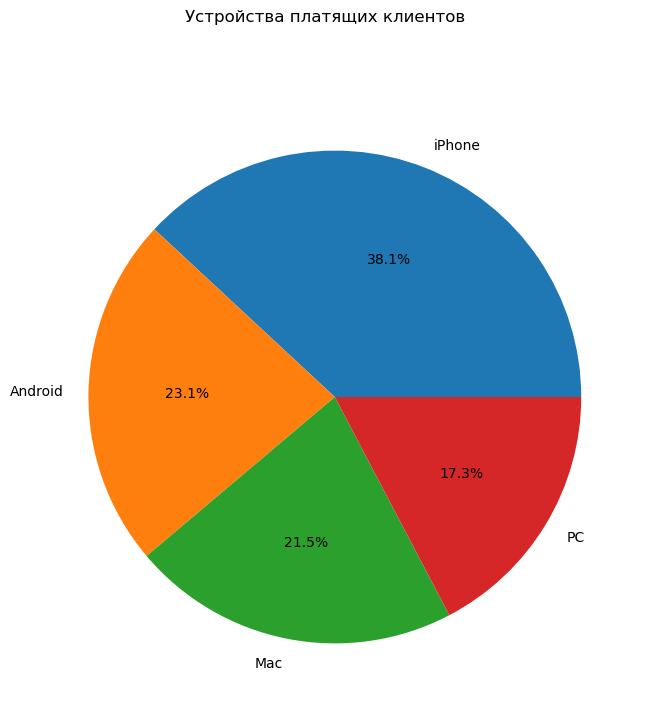

In [ ]:
pay_client.pivot_table(index=['device'],values=['user_id'],aggfunc='count').sort_values('user_id',ascending=False)\
.plot(kind='pie',subplots=True,figsize=(8,8),autopct='%1.1f%%',legend=False, ylabel='',title='Устройства платящих клиентов');

In [ ]:
region_buyer = pd.DataFrame()
region_buyer['users'] = profiles.groupby('channel')['user_id'].count()
region_buyer['users_part'] = ((region_buyer['users'] / profiles['region'].count()) * 100)
region_buyer['payer'] = profiles.groupby('channel').agg({'payer': 'sum'})
region_buyer['payer_part'] = ((region_buyer['payer'] / profiles.query('payer == True')['channel'].count()) * 100)
region_buyer.sort_values(by='payer_part', ascending=False).style.format({'payer_part': '{:.2f}%'})

,users,users_part,payer,payer_part
channel,,,,
FaceBoom,29144,19.428297,3557,40.05%
TipTop,19561,13.039971,1878,21.15%
organic,56439,37.623993,1160,13.06%
WahooNetBanner,8553,5.701696,453,5.10%
AdNonSense,3880,2.586529,440,4.95%
RocketSuperAds,4448,2.965175,352,3.96%
LeapBob,8553,5.701696,262,2.95%
OppleCreativeMedia,8605,5.736361,233,2.62%
lambdaMediaAds,2149,1.432590,225,2.53%


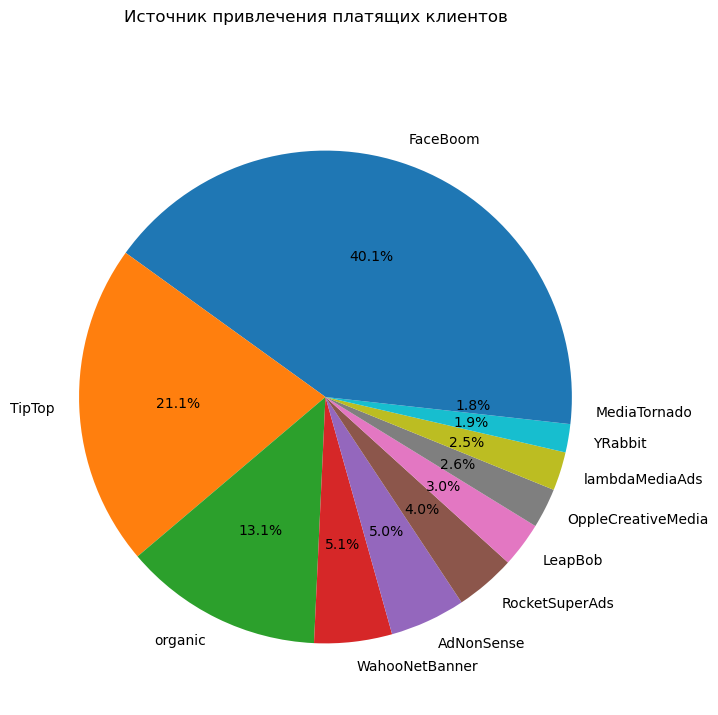

In [ ]:
pay_client.pivot_table(index=['channel'],values=['user_id'],aggfunc='count').sort_values('user_id',ascending=False)\
.plot(kind='pie',subplots=True,figsize=(8,8),autopct='%1.1f%%',legend=False, ylabel='',title='Источник привлечения платящих клиентов');

In [ ]:
pay_client.pivot_table(index=['channel'],values=['user_id'],aggfunc='count').sort_values('user_id',ascending=False)

,user_id
channel,
FaceBoom,3557
TipTop,1878
organic,1160
WahooNetBanner,453
AdNonSense,440
RocketSuperAds,352
LeapBob,262
OppleCreativeMedia,233
lambdaMediaAds,225


**Как можно увидеть по оценки платящих пользователей,по странам - USA захватило примущество (77.7% всех платящих пользователей). По платформам можно выделить Iphone(38%), но и другие девайсы находятся в районе 30%.\
В источнике привлечения видно, что хоть organic самый популярный метод, но не самый прибильный, лишь 3 место по кол-ву платящих пользователей. А вот TipTop(21%) и Faceboom (40%) привлекают больше всего платящих клиентов.**

## Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [ ]:
#Общая сумма затрат на рекламу
sum_costs = costs['costs'].sum()
round(sum_costs)

105497

                       costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22


array([<AxesSubplot:>], dtype=object)

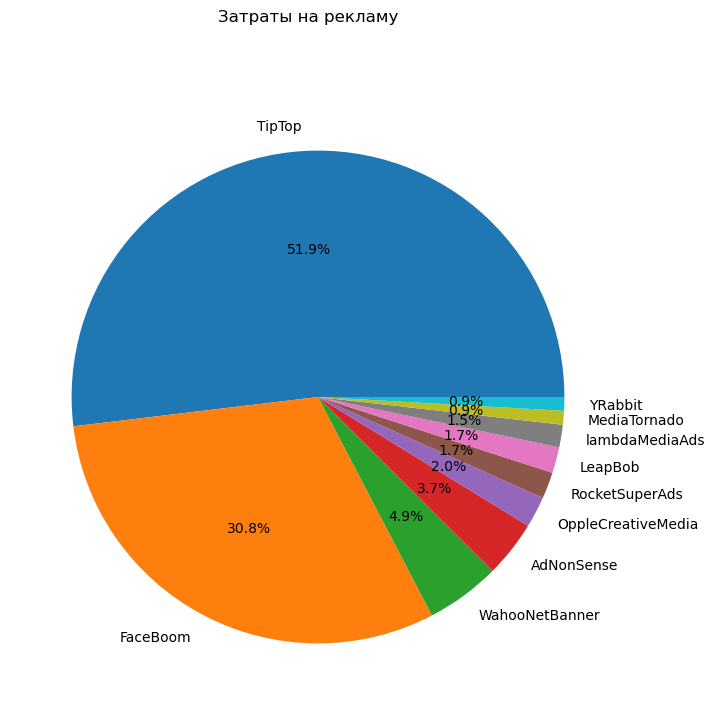

In [ ]:
print(costs.groupby('channel').sum().sort_values('costs',ascending=False))

costs.groupby('channel').sum().sort_values('costs',ascending=False).plot(kind='pie',subplots=True,figsize=(8,8)\
                                                                         ,autopct='%1.1f%%',legend=False, ylabel=''\
                                                                         ,title='Затраты на рекламу')

**Надо понять почему FaceBoom хотя в него вкладывают меньше чем TipTop приводит больше целевых пользователей**

In [ ]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month

Text(0.5, 1.0, 'Динамика изменения расходов по рекламному источнику по месяцам')

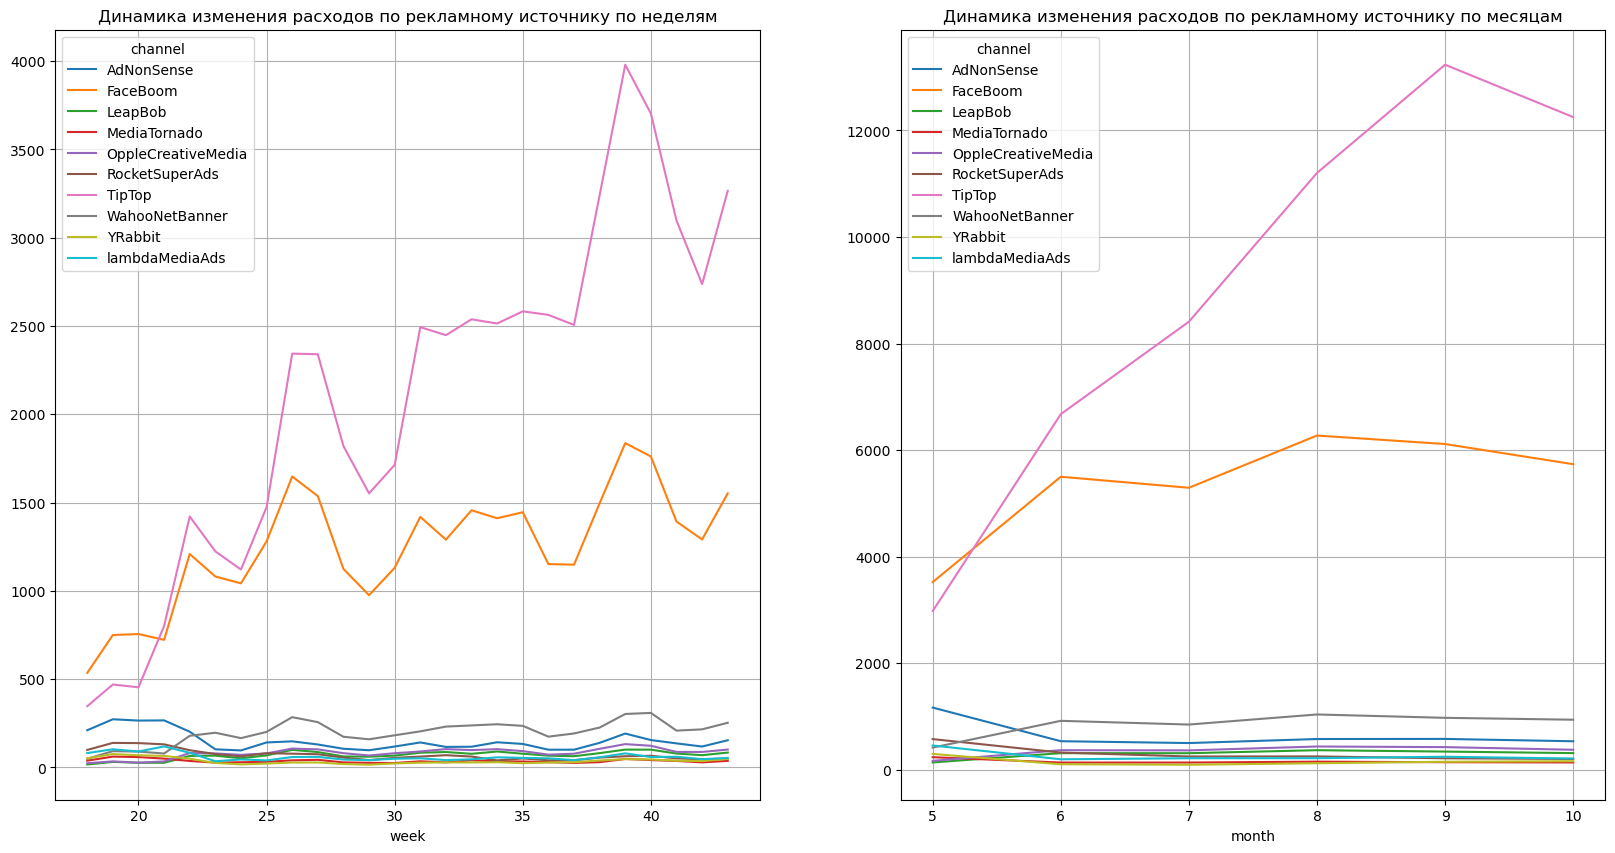

In [ ]:
costs.pivot_table(index='week',columns='channel',values='costs',aggfunc='sum').plot(figsize=(20,10),ax=plt.subplot(1,2,1),grid=True)
plt.title('Динамика изменения расходов по рекламному источнику по неделям')
costs.pivot_table(index='month',columns='channel',values='costs',aggfunc='sum').plot(figsize=(20,10),ax=plt.subplot(1,2,2),grid=True)
plt.title('Динамика изменения расходов по рекламному источнику по месяцам')

In [ ]:
profiles = get_profiles(visits,orders,costs,costs)
profiles[['channel','acquisition_cost']].groupby(by='channel').mean().sort_values('acquisition_cost',ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


**Вот и загвоздка TipTop явлеятся топ 1 по рекламному бюджету и при этом CAC там максимальное, и кол-во привлеченных пользователей всего лишь 20%. Но не будем делать поспешные выводы проанализируем LTC,ROI для формулировки точных выводов**

## Оценка окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

In [ ]:

#Всех пользователей проверка
profiles_for_ltv = profiles[profiles['channel'] != 'organic'].reset_index(drop=True)

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_for_ltv, orders, datetime(2019, 11, 1).date(), 14
)


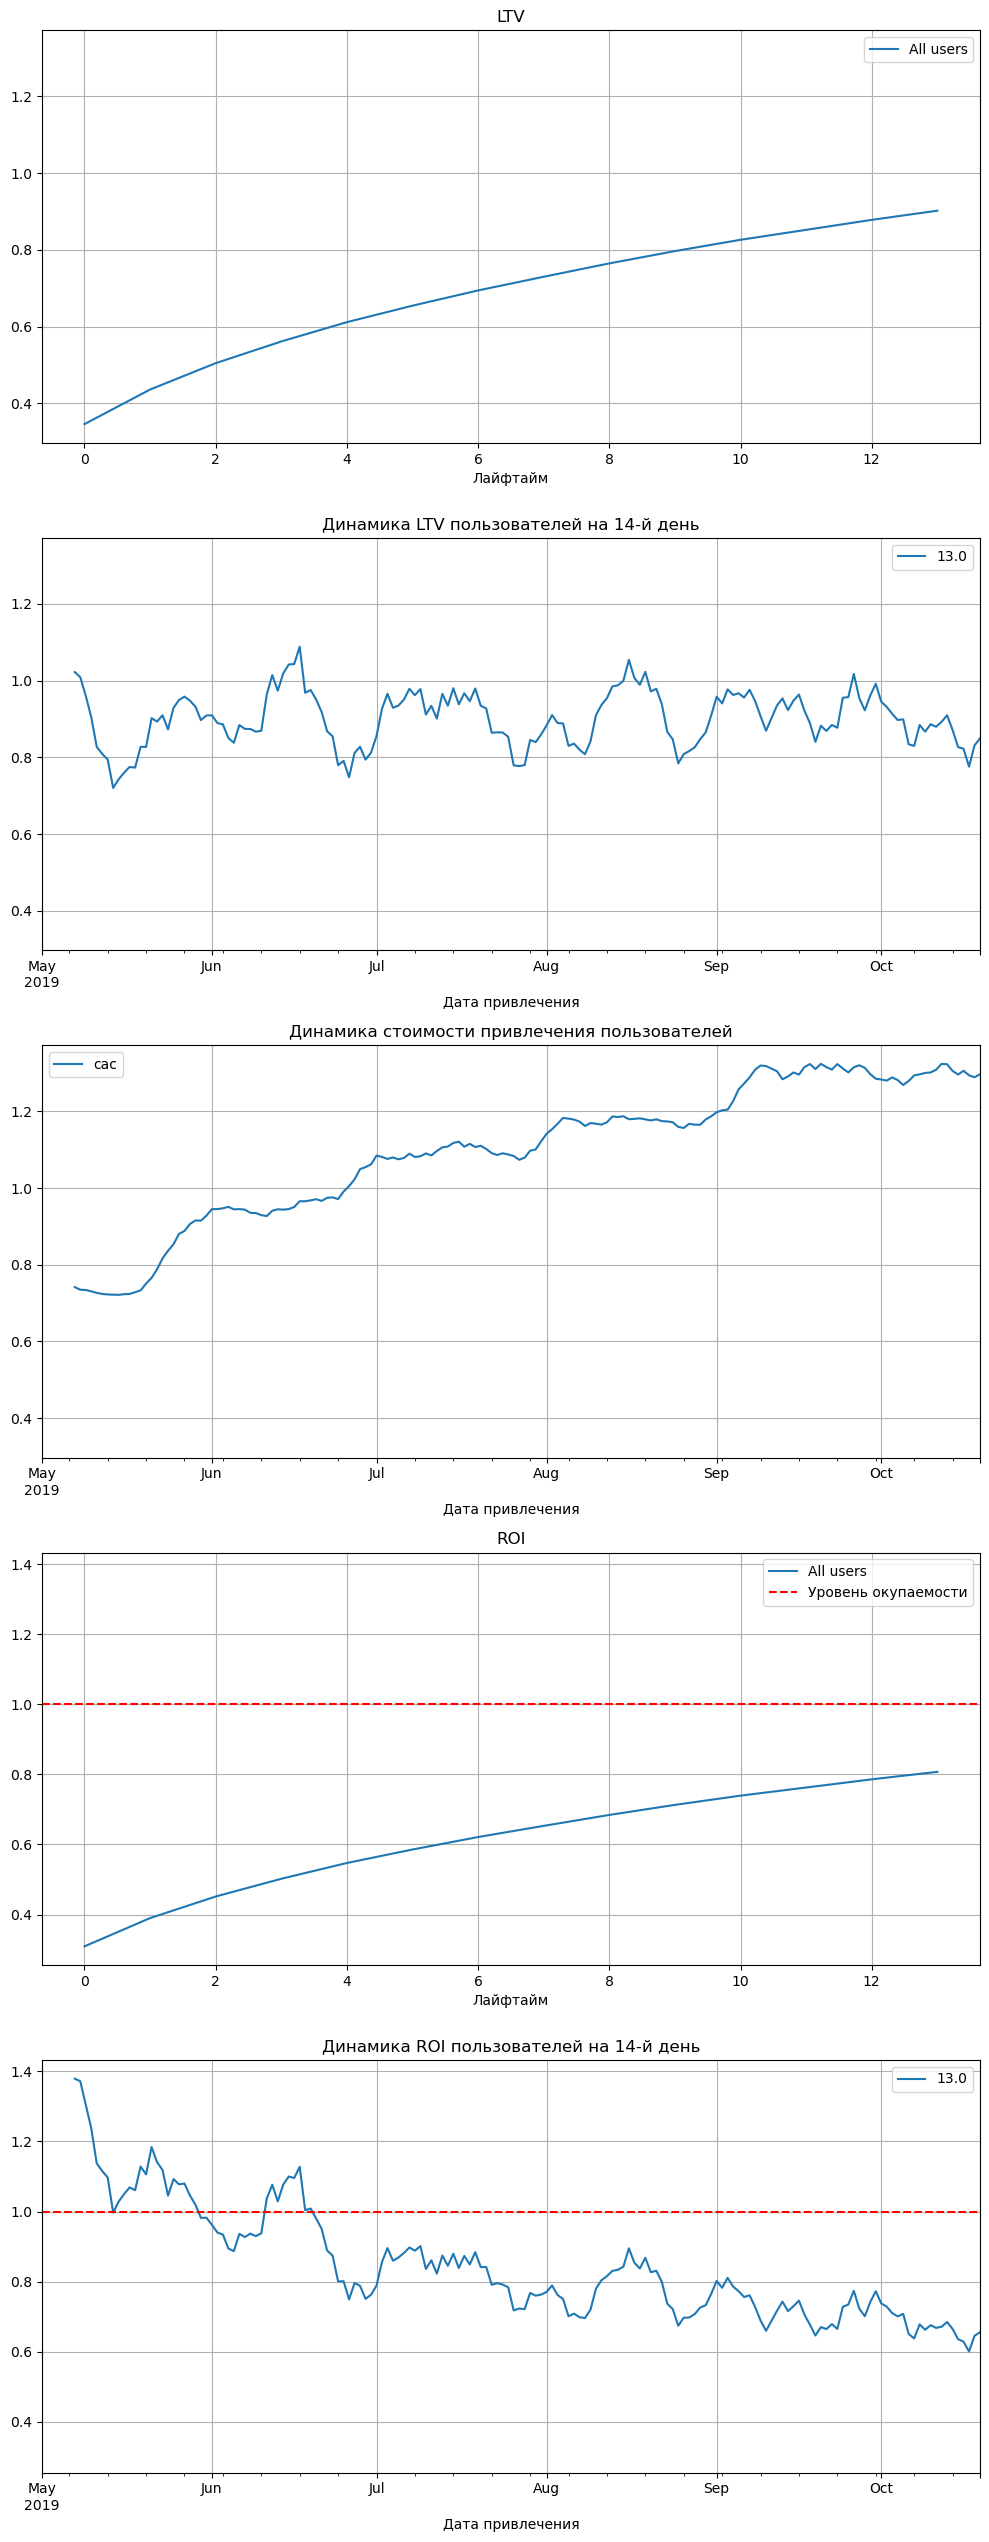

In [ ]:
#Всех пользователей проверка
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14)

In [ ]:
#Всех пользователей проверка
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14
)

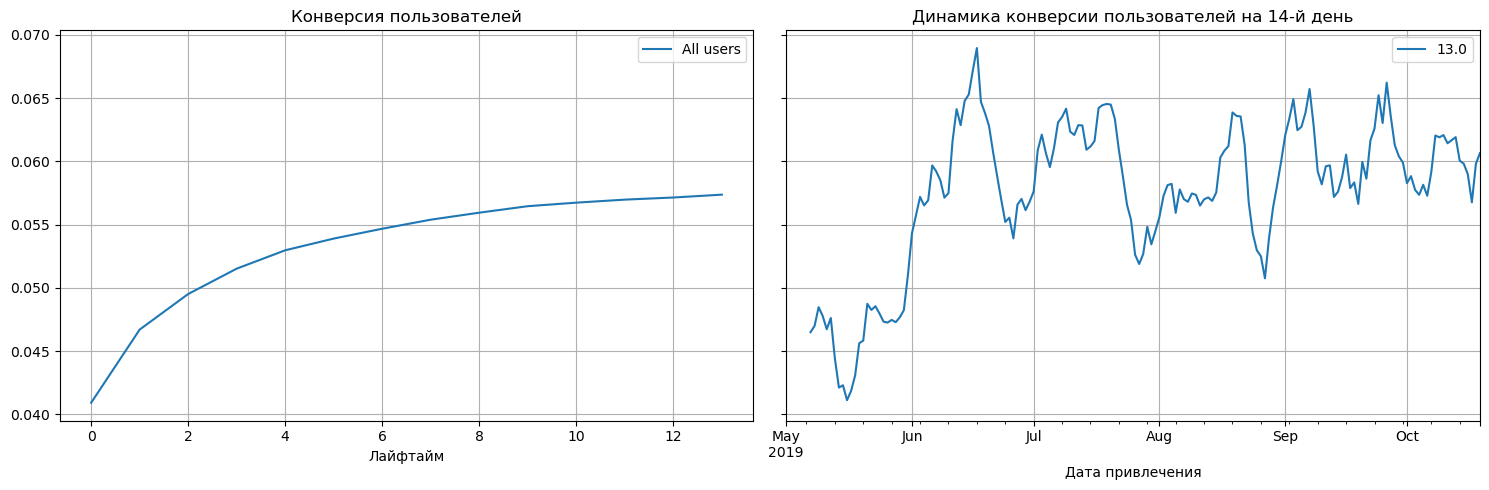

In [ ]:
#Всех пользователей проверка
plot_conversion(conversion, conversion_history, 14) 

In [ ]:
#Всех пользователей проверка
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14
)

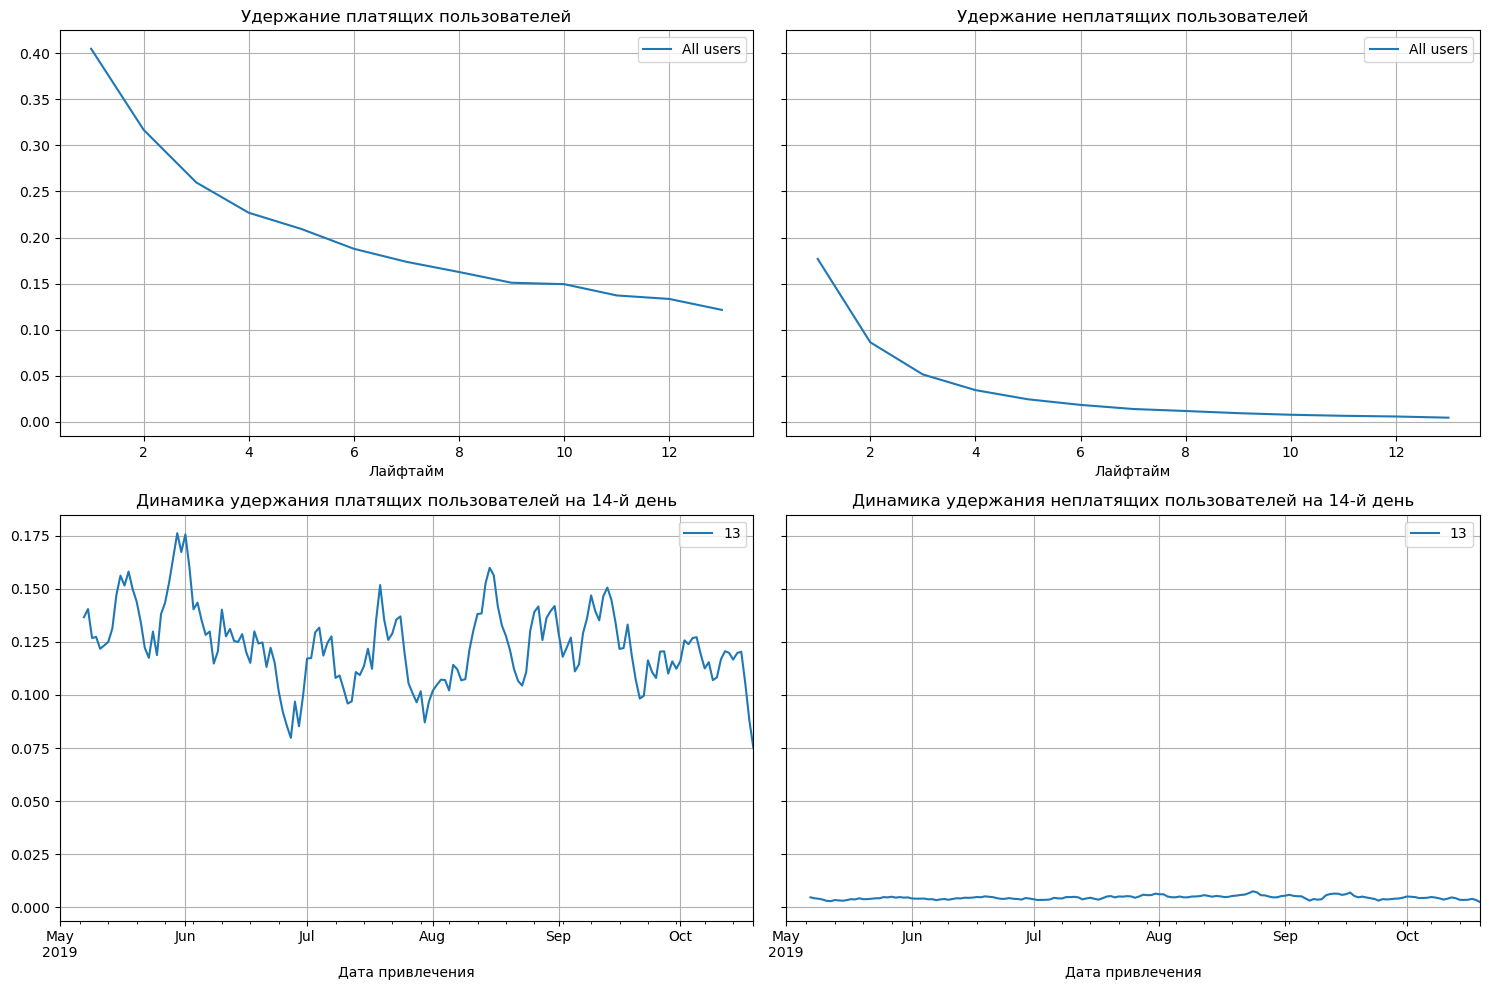

In [ ]:
#Всех пользователей проверка
plot_retention(retention, retention_history, 14) 

**Все графики выглядят хорошо, только есть несколько моментов которые настараживают:\
 -ROI так и не смогла выйти за 1, и динамика ее странно снижается\
 -Очень резкое падение удержания платящих пользователей**

In [ ]:
#Разбивка пользователей по девайсам
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

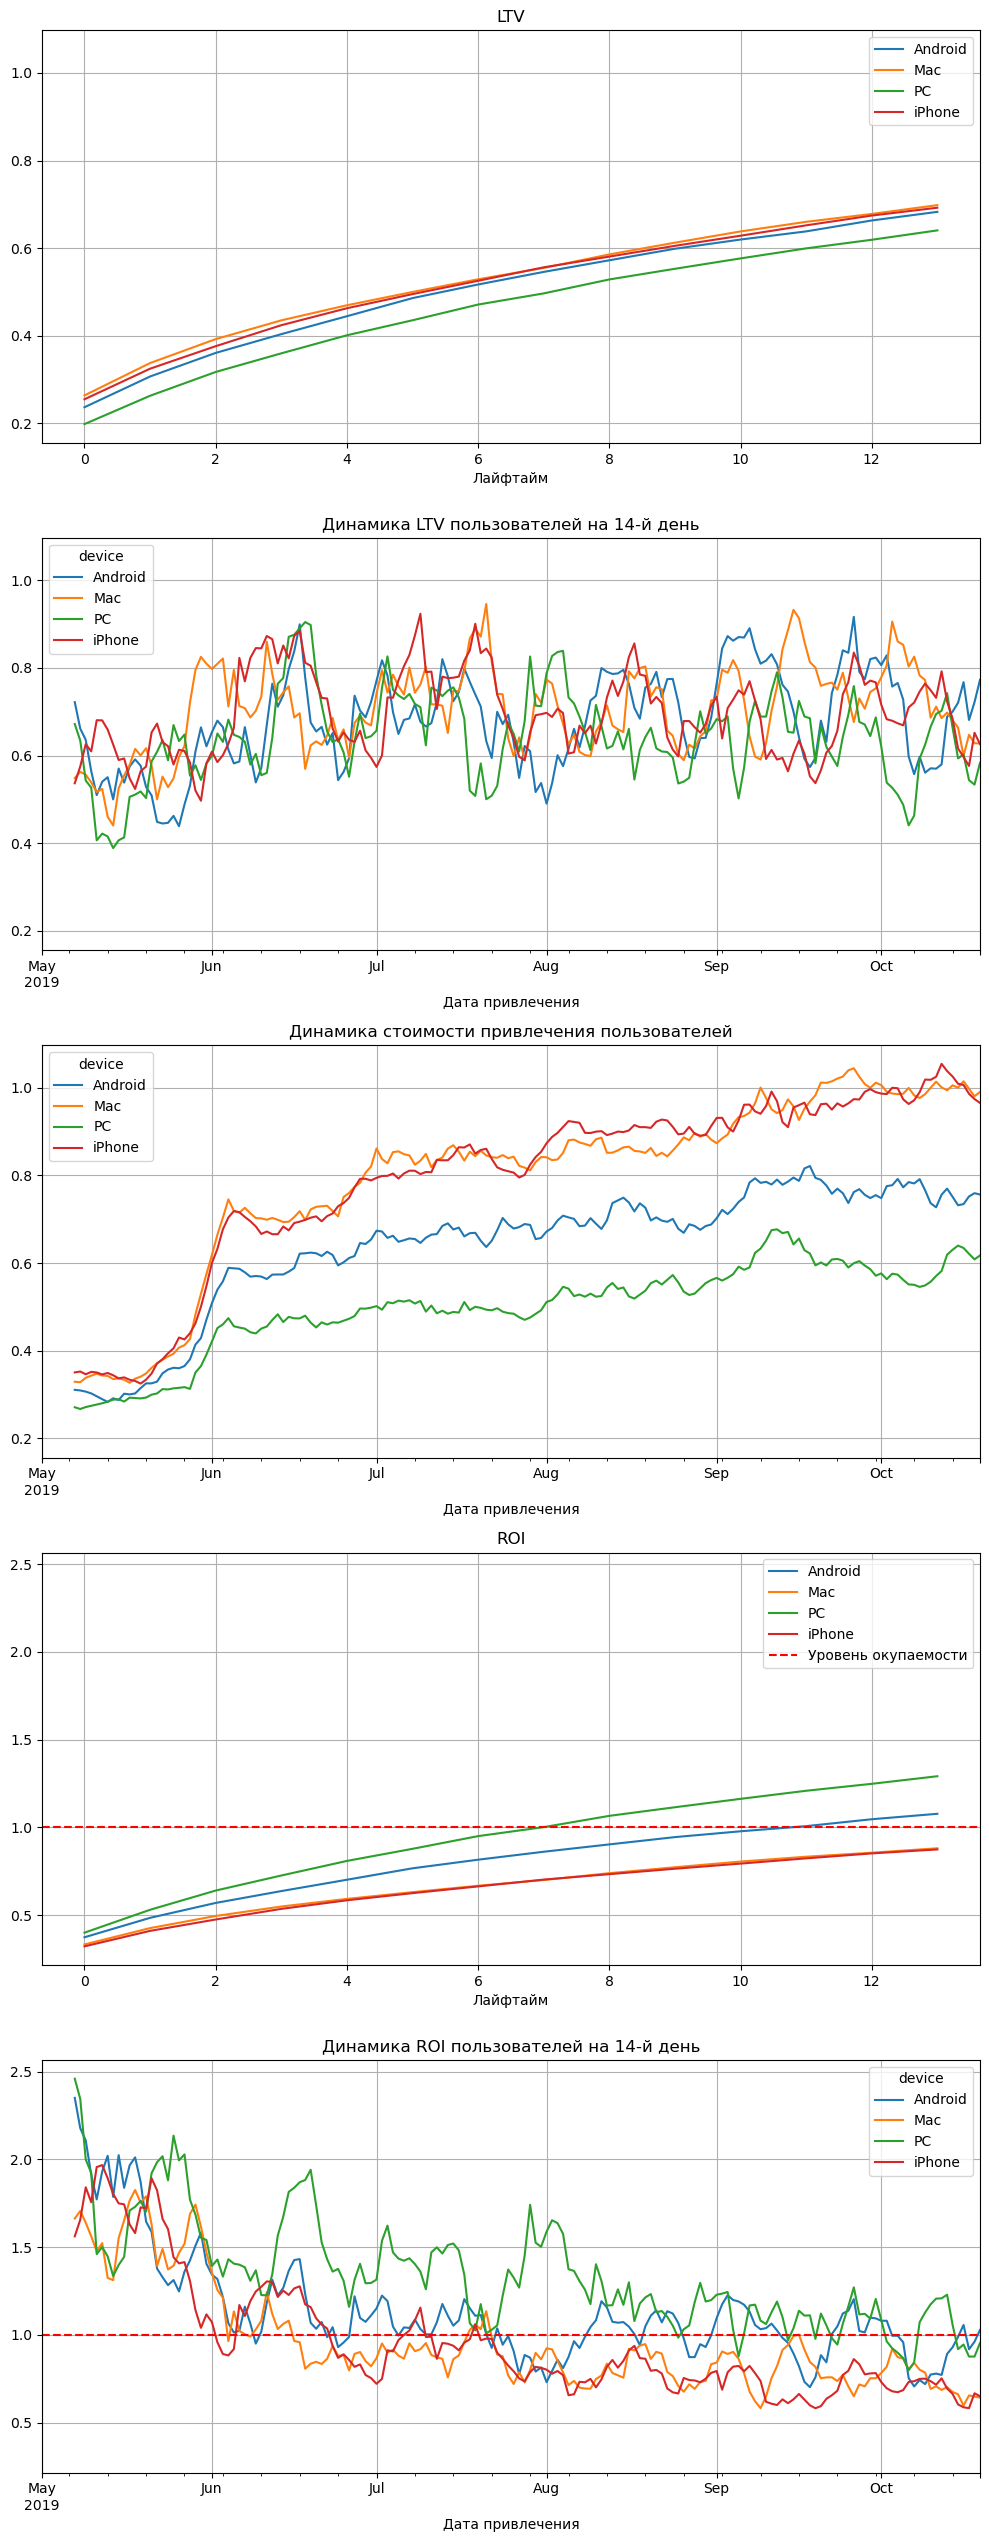

In [ ]:
#Разбивка пользователей по девайсам
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14)

**Наблюдается динамика снижения ROI, но еще удивительно, что пользователи с Iphone и Mac не окупились**

In [ ]:
#Разбивка пользователей по странам
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)

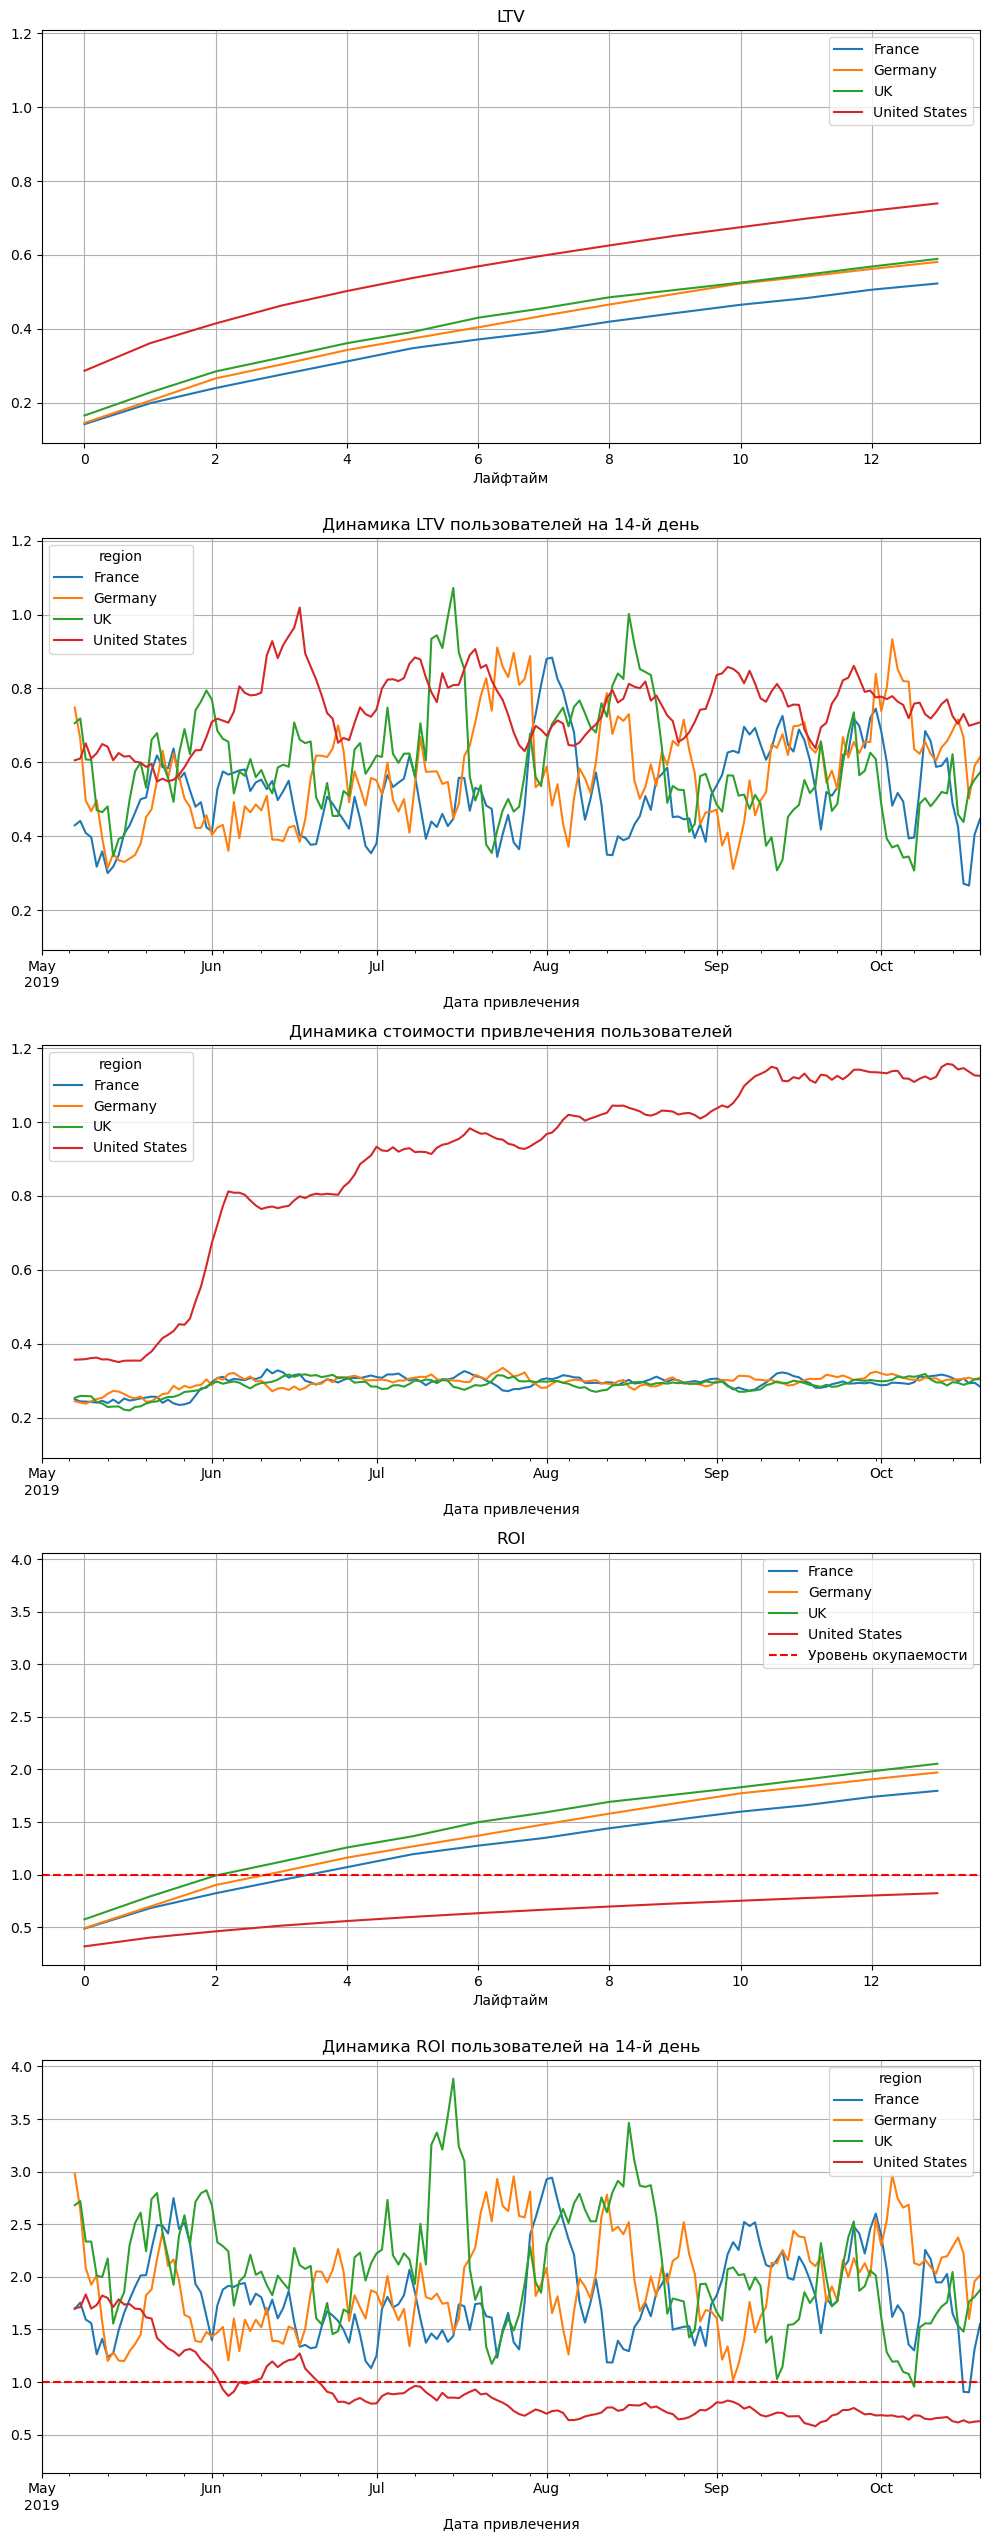

In [ ]:
#Разбивка пользователей по каналам странам
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

**Резкий подъем цены пользователя в USA, а так же факт, что этот регион не смог окупиться, может означать, что компания привлекла очень много клиентов из этого региона и стоит поменять источники размещения рекламы или сосредоточиться на других регинов. Лучше рассмотреть новые варианты размещения рекламы, так как USA приносит основной доход, так что надо искать новые источники с лояльными клиентами**

In [ ]:
#Разбивка пользователей по каналам привлечения
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

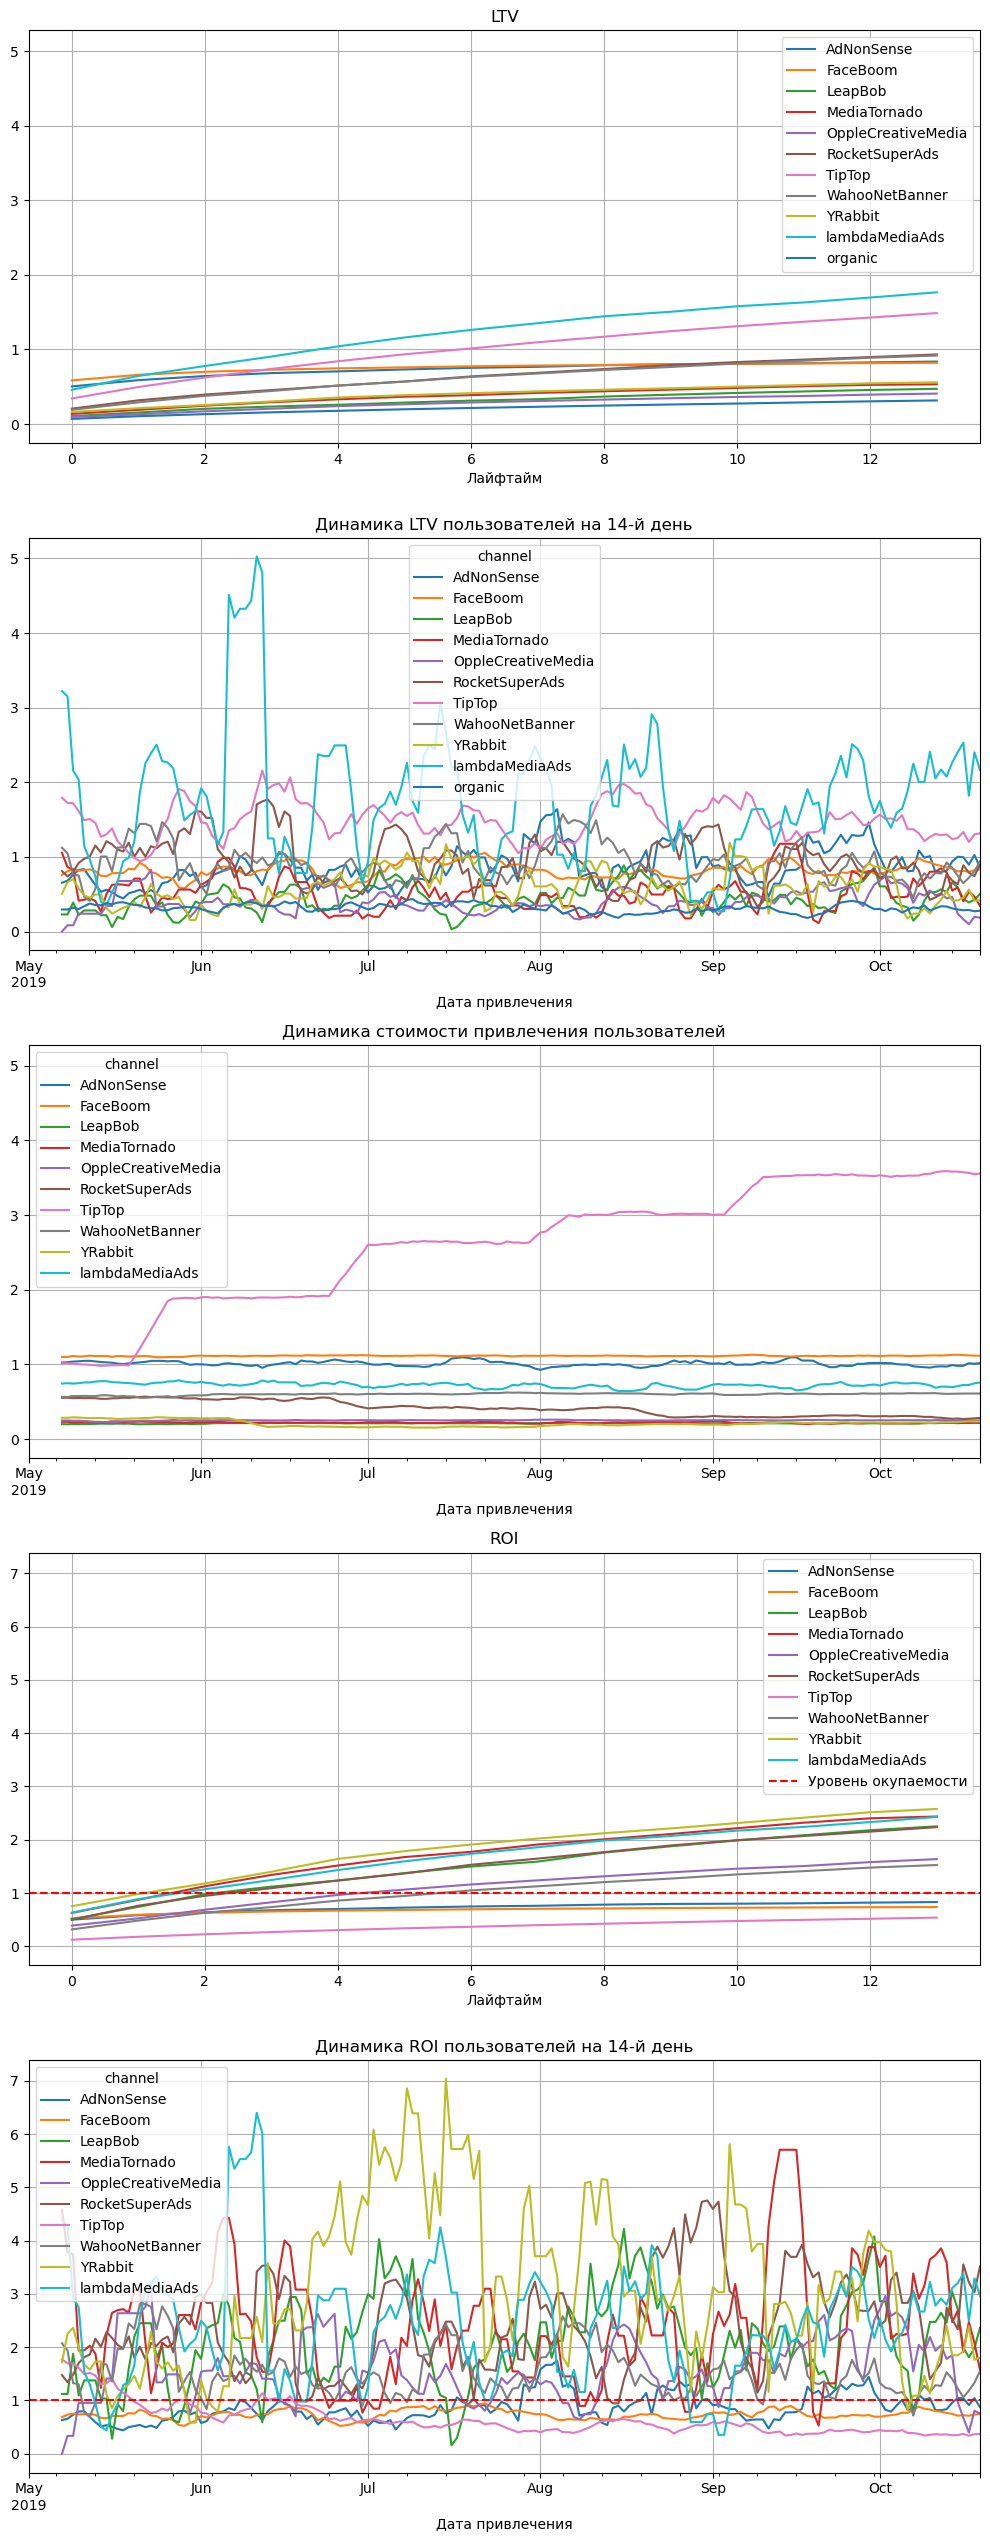

In [ ]:
#Разбивка пользователей по каналам привлечения
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14) 

In [ ]:
#Графики конверсии в разрезе каналов 
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
) 

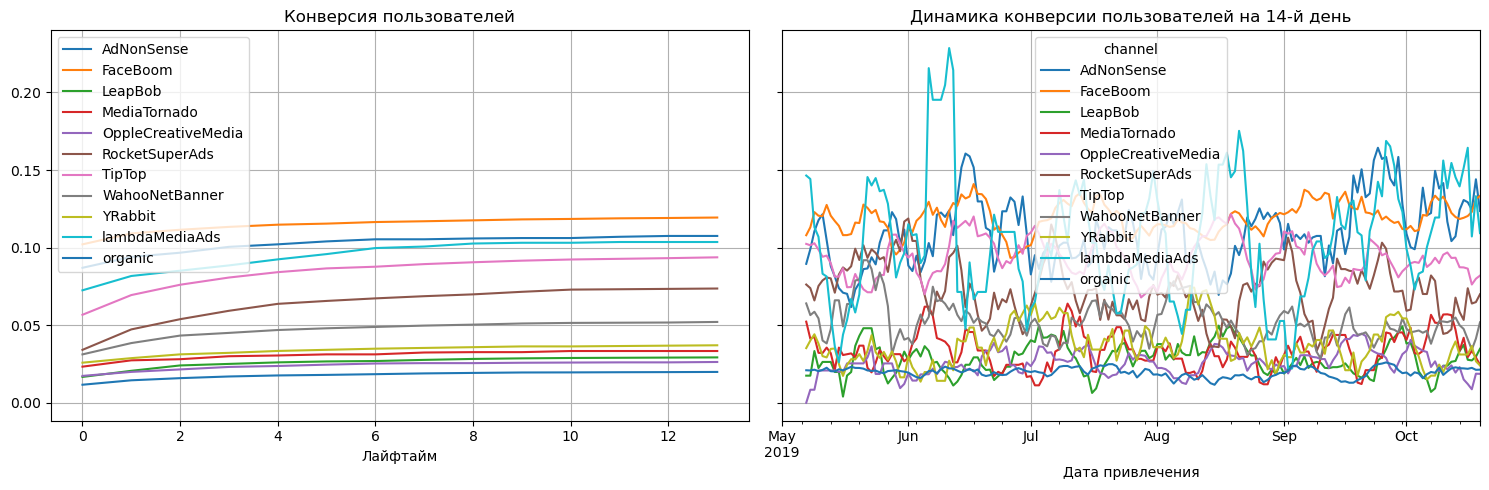

In [ ]:
plot_conversion(conversion, conversion_history, 14) 

In [ ]:
#Графики удержания в разрезе каналов
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

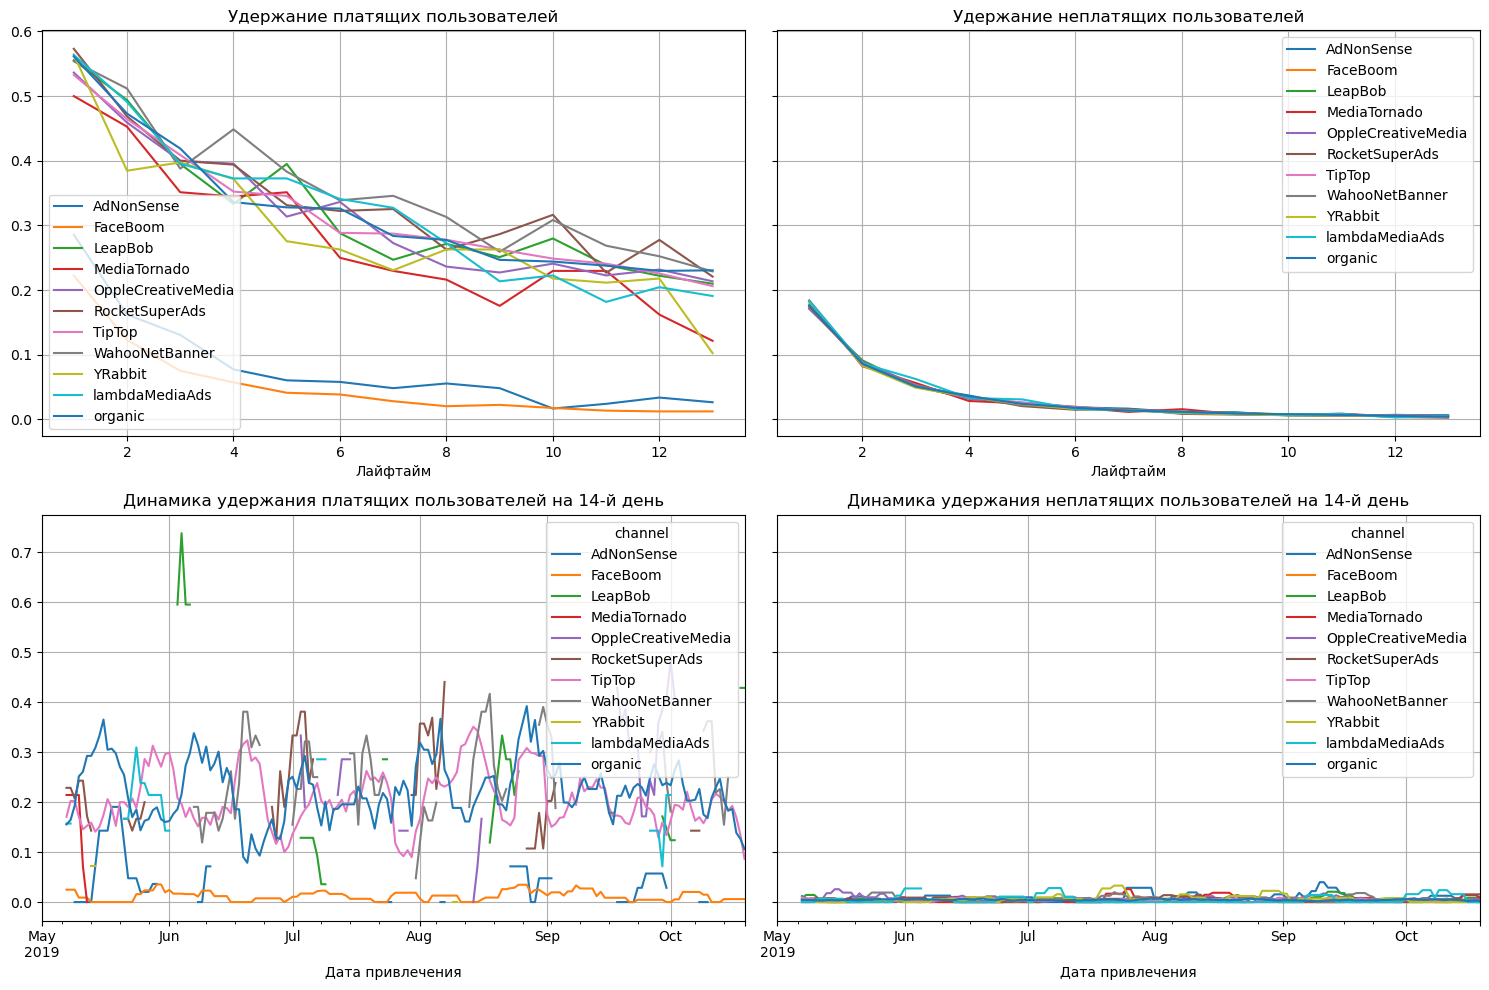

In [ ]:
#Всех пользователей проверка
plot_retention(retention, retention_history, 14) 

**Можем заметить как поэтапно увеличивалось CAC у TipTop. При чем многие компании вышли на уровень окупаемости, так что проблема явно не в этом**

## Выводы

**Выводы**\
Окупается ли реклама, направленная на привлечение пользователей в целом?
 - Нет, рекламе не хватает немного чтобы польностью себя окупать, так что надо искать причину этого и устранять.
 
Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
 - Стоит обратить внимание, на такие вещи:
     - Iphone,Mac не окупают рекламу, возможны ошибки в приложении
     - Особое внимание уделить USA, как источнику основного дохода и при этом единственной странне, которая не окупила рекламу
     Причины этого могут быть в исчерпании лояльнях клиентов на площадках где размещалась реклама, необходим поиск новых вариантов размещения.
     - Почти все рекламные каналы окупались. Но канал TipTop имеет резкое повышение роста CAC, возможно как раз этот канал рассположен в USA. Так же канал FaceBoom приводит платящих, но низкокачественных клиентов. Можно сделать вывод, что большие(дорогие) рекламные компании не окупаются. Так же у двух дорогих компаний BetBoom И AdNonSense очень низкие показатели удержания
     
Чем могут быть вызваны проблемы окупаемости?
 - Проблемы окупаемости вызваны исчерпанием лояльных клиентов на площадках приносящих основной доход или неэффективной рекламой.

Причин неэффективности привлечения пользователей несколько:
 - Увелечение CAC в USA
 - Увелечение CAC в TipTop
 - Неокупаемость Iphone (Возможны ошибки в приложении)
 - Рост CAC на всех девайсах 
 
Возможные причины:
 - Увеличение конкуренции: если на рынок внезапно появляется больше конкурентов, стоимость рекламы и привлечения клиентов может возрасти из-за увеличения спроса.
  - Анализ конкурентов, размещение на площадках с меньшей конкуренцией
 - Неэффективная реклама: если рекламные сообщения компании не находят отклика у целевой аудитории, это может привести к снижению конверсии и повышению CAC.
  - Проверка рекламных компаний на результативность, и сравнение компаний за разные периоды
  - **Можно заметить, что две самые большие компании TipTop и BetBoom - не окупаются. Желательно узнать приорететы пользователей BetBoom потому что от нее приходят самые платящие клиенты, но надо поработать над удержанием. Можно рассмотреть компании YRabbit, MediaTornado, lambdaMediaAds.**
 - Плохой пользовательский опыт
  - **Проверить Баги, невозомжность пользоваться на разных площадках**
 - Изменения в продукте или услуге: если компания вносит изменения в свой продукт или услугу, которые приводят к увеличению затрат на производство или снижению удовлетворенности клиентов, это может привести к повышению CAC.
  - Отслеживание последних изменений, опрос клиентов
